In [1]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
# 1. UNZIP THE DATASET
dataset_path = "dataset-resized.zip"
unzip_path = "dataset-resized"
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

In [9]:
# 2. SET UP DATA GENERATORS
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # rescaling and 20% validation split
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(unzip_path, "dataset-resized"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(unzip_path, "dataset-resized"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [10]:
# 3. APPLY TRANSFER LEARNING WITH VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# 4. TRAIN THE MODEL
history = model.fit(
    train_generator,
    epochs=10,  # You can adjust the number of epochs
    validation_data=validation_generator
)

Epoch 1/10
64/64 [==============================] - 138s 2s/step - loss: 1.4510 - accuracy: 0.4156 - val_loss: 1.0708 - val_accuracy: 0.5646
Epoch 2/10
64/64 [==============================] - 140s 2s/step - loss: 0.9086 - accuracy: 0.6658 - val_loss: 1.0081 - val_accuracy: 0.6322
Epoch 3/10
64/64 [==============================] - 138s 2s/step - loss: 0.7591 - accuracy: 0.7282 - val_loss: 0.9076 - val_accuracy: 0.6938
Epoch 4/10
64/64 [==============================] - 139s 2s/step - loss: 0.6496 - accuracy: 0.7611 - val_loss: 0.8890 - val_accuracy: 0.6759
Epoch 5/10
64/64 [==============================] - 137s 2s/step - loss: 0.5779 - accuracy: 0.7967 - val_loss: 0.8968 - val_accuracy: 0.6819
Epoch 6/10
64/64 [==============================] - 139s 2s/step - loss: 0.5127 - accuracy: 0.8252 - val_loss: 0.8513 - val_accuracy: 0.6879
Epoch 7/10
64/64 [==============================] - 138s 2s/step - loss: 0.4435 - accuracy: 0.8581 - val_loss: 0.8994 - val_accuracy: 0.6899
Epoch 8/10
64

In [12]:
# 5. EVALUATE AND PREDICT ON TEST SET
test_generator = test_datagen.flow_from_directory(
    os.path.join(unzip_path, "dataset-resized"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
loss, accuracy = model.evaluate(train_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Found 2527 images belonging to 6 classes.
79/79 [==============================] - 114s 1s/step - loss: 0.4310 - accuracy: 0.8619
Test Loss: 0.43101072311401367
Test Accuracy: 0.8618915677070618


In [13]:
# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

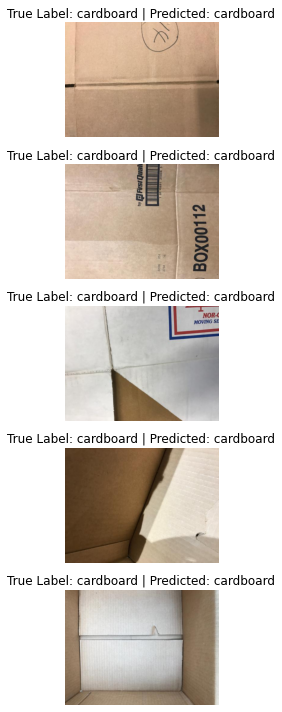

In [14]:
# 6. VISUALIZE SOME PREDICTIONS
class_labels = list(test_generator.class_indices.keys())
sample_images = test_generator.filepaths[:5]
sample_labels = [class_labels[i] for i in test_generator.labels[:5]]
sample_predictions = [class_labels[i] for i in predicted_classes[:5]]

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_images):
    plt.subplot(5, 1, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"True Label: {sample_labels[i]} | Predicted: {sample_predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

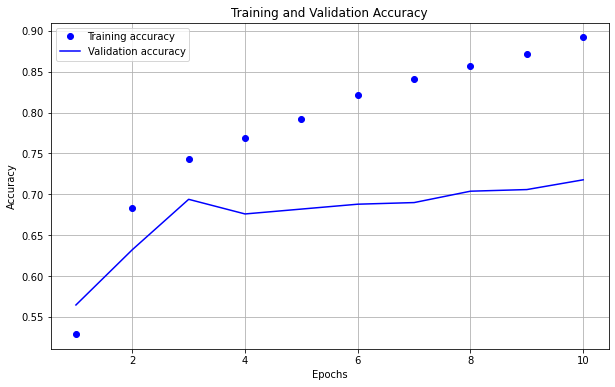

In [16]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    """
    Plot training and validation accuracy from the training history.
    """
    
    # Extract accuracy values
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_accuracy(history)